# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.5: Bayesian inference

### 1.5.3 Representing prior knowledge: postcodes

In the last module we looked at incorporating prior knowledge into our models, but effectively cheated by saying "all outcomes are just as likely, until we have data". Often we have more information than that.

In this module we look at how to take prior information about the domain we are investigating, and using that information to alter our model.


- France's *La Poste* has used automated sorting since 1964.
- Handwritten digit recognition has been well studied.
- In order to use digit recognition in practice for sorting mail, we need a *prior* model for how probable each postcode is, independent of each actual digitized hand-written digit image in front of us.

A sample of some Australian and international postcodes:
- 2000 (Sydney)
- 3122 (Hawthorn, VIC)
- 4350 (used for 44 towns near Toowoomba, QLD)
- 8007 (PO boxes in Collins Street West)
- A-1220 (Vienna, Austria)
- Tsuen Wan (Hong Kong): no postcodes in HK
- 02138 (Cambridge, MA)
- EC1V 4AD (London)


### A prior for Australian postcodes

**What prior information do we have?**

- Do all Australian postcodes have 4 digits? Yes.
- What range? 0200 to 9944
- States:
   - NSW: postcodes 1000-1999 (PO boxes), 2000-2599, 2620-2899, 2921-2999
   - ACT: 0200-0299 (PO boxes), 2600-2619, 2900-2920
   - VIC: 3000-3999, 8000-8999 (PO boxes)
   - QLD: 4000-4999, 9000-9999 (PO boxes)
   - SA: 5000-5799, 5800-5999 (PO boxes)
   - WA 6000-6797, 6800-6999 (PO boxes)
   - TAS: 7000-7799, 7800-7999 (PO boxes)
   - NT: 0800-0899, 0900-0999 (PO boxes)

**Also:**

- 25% of all mail goes to these CBD postcodes: 2000, 2001, 3000, 3001, 4000, 4001, 5000, 5001, 6000, 6001.
- We can look up population for each postcode. Or, if we don't have population info by postcode, we could seed the prior with state population data.
- Within each state xxxx, 80% of mail goes to x0xx and x1xx (metropolitan city areas and suburbs).

### How do we encode this prior information for machine learning purposes?

### Goal: construct a prior $p(\textrm{postcode})$ over all 4-digit postcodes

### Valid ranges


In [1]:
postcodes_by_state = dict((
    ('Australian Capital Territory', set(range(2600, 2620)) | set(range(2900, 2920))),
    ('New South Wales', set(range(2000, 3000)) - set(range(2600, 2620)) - set(range(2900, 2920))),
    ('Victoria', set(range(3000, 4000))),
    ('Queensland', set(range(4000, 5000))),
    ('South Australia', set(range(5000, 5800))),
    ('Western Australia', set(range(6000, 6798))),
    ('Tasmania', set(range(7000, 7800))),
    ('Northern Territory', set(range(800, 900)))
))

### State populations

We will start by using state populations as a proxy for really knowing the proportion of mail sent to each postcode.

(If we obtain more data, we can update and improve our model by applying Bayes' theorem later.)

In [2]:
import pandas as pd

state_populations = pd.read_hdf('data/aus_state_populations.h5')

In [3]:
state_populations

,Population,%
State,,
New South Wales,7757843,32.0
Victoria,6100877,25.2
Queensland,4860448,20.1
South Australia,1710804,7.1
Western Australia,2623164,10.8
Tasmania,519783,2.1
Northern Territory,245657,1.0
Australian Capital Territory,398349,1.6


These are the desired feature expectations for each state.

In [4]:
# Source of the data:
def fetch_state_populations():
    url = 'http://www.ausstats.abs.gov.au/Ausstats/subscriber.nsf/0/D52DEAAFCEDF7B2ACA2580EB00133359/$File/31010do001_201609.xls'

    state_pop = pd.read_excel(url, sheetname='Table_8', skiprows=6,
                  names=['State', 'Population', '%'])

    state_pop.set_index('State', inplace=True)

    drop_row_idx = list(state_pop.index).index('Other Territories')

    state_pop.drop(state_pop.index[drop_row_idx:], inplace=True)

    state_pop['Population'] = state_pop['Population'].astype(int)
    # state_pop.to_hdf('state_populations.h5', key='populations')
    return state_pop

### How to incorporate this?

... to model the probability of e.g. $p(\textrm{postcode}=3122)$?

In [5]:
def prior_state(state):
    return state_populations['%'].loc[state] / 100

In [6]:
prior_state('New South Wales')

0.32

Now we have a prior $p(\text{state})$.

### From the definition of conditional probability:

$p(\textrm{postcode}) = \sum_{\textrm{all states}} p(\textrm{postcode | state}) p(\textrm{state})$

#### Exercise

Assuming you have a function `prior_postcode_given_state(postcode, state)`, implement this as a function `prior_postcode(postcode)`.

### Solution hint:

Iterate over all states in `state_populations.index`.

### Solution:


In [7]:
def prior_postcode(postcode):
    p = 0.0
    for state in state_populations.index:
        p += prior_postcode_given_state(postcode, state) * prior_state(state)
    assert p <= 1
    return p

#### Exercise

1. Write the function `prior_postcode_given_state(postcode, state)`.

Assume you can assign equal probability to each valid postcode in the corresponding state (or 0 probability for the wrong state).


You can test your code by trying these two examples:

In [8]:
# prior_postcode_given_state(3122, 'Victoria')

# prior_postcode(3122)

*For solutions, see `solutions/prior_postcode_given_state.py`*

In [9]:
%run -i solutions/prior_postcode_given_state.py

### What did we do?

We informally constructed a prior model that was as **flat** (uninformative) as possible **subject to a constraint** that the proportion of mail being delivered to a postcode is equal to the state's population, divided by the number of postcodes for that state.

### Consider now: how would you update the model to reflect that ...

1. 25% of all mail goes to one of the CBD postcodes; and
2. Within each state xxxx, 80% of mail goes to x0xx and x1xx (metropolitan city areas and suburbs)?

### Maximum entropy models: the easy way

Here we see how to derive such prior models in a more systematic and principled way using the `maxentropy` package.

You can install it like this:
```
pip install maxentropy
```

**Step 1: Set up the domain (or "sample space")**

In [10]:
import numpy as np
samplespace = np.arange(10000, dtype=np.uint16)

In [11]:
samplespace

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16)

**Step 2: Set up a list of feature functions whose expectations you want to constrain**

In [12]:
def is_valid(postcodes):
    return [200 <= postcode < 10000 for postcode in postcodes]

In [13]:
# def in_nsw(postcodes):
#     return [postcode in postcodes_by_state['New South Wales'] for postcode in postcodes]
# etc.

In [14]:
def in_given_state(state):
    def in_state(postcodes):
        return [postcode in postcodes_by_state[state] for postcode in postcodes]
    return in_state

In [15]:
state_populations.index

Index(['New South Wales', 'Victoria', 'Queensland', 'South Australia',
       'Western Australia', 'Tasmania', 'Northern Territory',
       'Australian Capital Territory'],
      dtype='object', name='State')

In [16]:
features = [is_valid] + \
           [in_given_state(state) for state in state_populations.index]

In [17]:
features

[<function __main__.is_valid(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>]

**Step 3: create a `MinDivergenceModel` object from this list of features and sample space**

In [18]:
from maxentropy import MinDivergenceModel

model = MinDivergenceModel(features, samplespace, vectorized=True)

**Step 4: define your desired array of expected feature function values (one for each feature)**

In [19]:
pop = state_populations['%'] / 100
pop

State
New South Wales                 0.320
Victoria                        0.252
Queensland                      0.201
South Australia                 0.071
Western Australia               0.108
Tasmania                        0.021
Northern Territory              0.010
Australian Capital Territory    0.016
Name: %, dtype: float64

In [20]:
state_populations['%'].sum()

99.9

(This excludes the other territories, like Norfolk Island. Ignore this for now.)

In [21]:
# Target expectations
k = np.atleast_2d(np.r_[1, pop.values])

In [22]:
k

array([[1.   , 0.32 , 0.252, 0.201, 0.071, 0.108, 0.021, 0.01 , 0.016]])

In [23]:
len(features) == k.shape[1]

True

**Step 5: fit your model under those constraints**

In [24]:
model.fit(k)

/Users/ashkfarjami/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


MinDivergenceModel(features=[<function is_valid at 0x7fe5b3444e50>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b34444c0>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a040>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a0d0>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a160>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a1f0>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a280>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a310>,
                             <function in_given_state.<locals>.in_state at 0x7fe5b345a3a0>],
                   samplespace=array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16),
                   vectorized=True)

In [25]:
model.expectations() - k

array([[-4.04218898e-08, -7.21599679e-08, -7.89633941e-07,
         7.45644801e-07, -3.70129965e-07,  1.00904637e-06,
         5.08948233e-08, -2.96428910e-07, -1.79097180e-07]])

In [26]:
np.allclose(model.expectations(), k, atol=1e-6)

True

**Result: our fitted prior model is given by `model.probdist()`**

In [27]:
model.probdist()

array([2.02108897e-10, 2.02108897e-10, 2.02108897e-10, ...,
       2.32417815e-07, 2.32417815e-07, 2.32417815e-07])

In [28]:
assert len(model.probdist() == len(samplespace))

We now have a prior probability $\textrm{prior}(\textrm{postcode})$ for each 4-digit postcode.

### What are the most probable postcodes?


In [29]:
p = model.probdist()
np.argsort(p)[::-1]

array([2915, 2910, 2917, ...,  128,  127,    0])

### Visualized


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'probability')

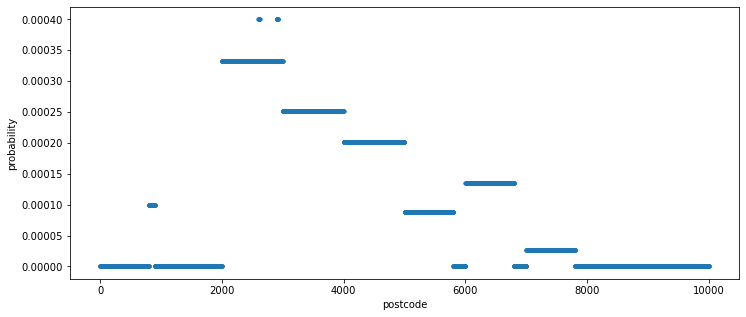

In [31]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(samplespace, p, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

#### Exercise incorporating more prior knowledge

Now try to incorporate the additional prior knowledge that 40% of all mail
goes to the following CBD postcodes:

In [32]:
CBD_POSTCODES = {2000, 2001, 3000, 3001, 4000, 4001, 5000, 5001, 6000, 6001}

**Solution hint:**
1. Define a new feature function `in_cbd(postcode)` and append this to your list of features.
2. Add an additional value (0.4) to your array of constraint values of feature expectations.
3. Re-create your model passing in your new features.
4. Re-fit your model passing in the new constraints.

*For solutions, see `solutions/representing_prior_information.py`*

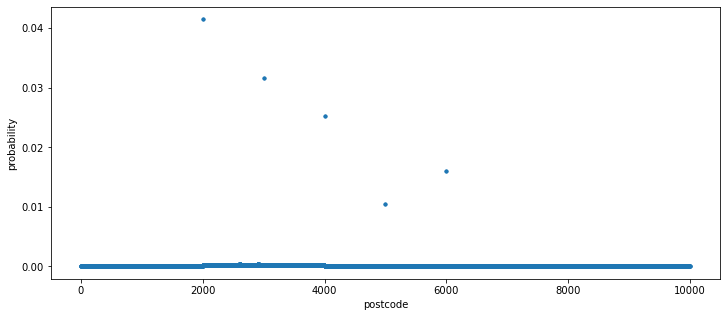

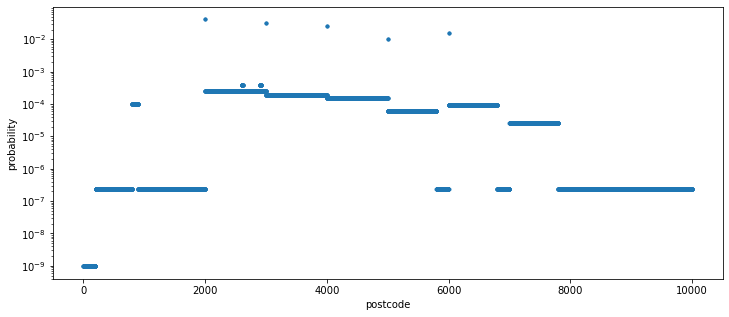

In [33]:
%run -i solutions/representing_prior_information.py

### More prior knowledge: CBD, inner suburbs, outer suburbs, regional centres

Here is an example of how to incorporate this extra information:

- Within each state xxxx, 80% of mail goes to x0xx and x1xx (metropolitan city areas and suburbs).

In [34]:
def which_ring(postcodes):
    """
    Returns
    -------
    0 if postcode is x0xx
    100 if postcode is x1xx
    200 if postcode is x2xx
    ... otherwise
    """
    return [postcode % 1000 - postcode % 100 for postcode in postcodes]

In [35]:
which_ring([1234, 800, 2900, 3000, 2001, 2099, 3122])

[200, 800, 900, 0, 0, 0, 100]

In [36]:
def in_city_metropolitan_area(postcodes):
    return [ring == 0 or ring == 100 for ring in which_ring(postcodes)]

In [37]:
in_city_metropolitan_area([3136, 3122, 2001])

[True, True, True]

In [38]:
features3 = features2 + [in_city_metropolitan_area]

In [39]:
k3 = np.c_[k2, 0.8]  # k2 comes from your solution to the previous exercises

In [40]:
k3

array([[1.   , 0.32 , 0.252, 0.201, 0.071, 0.108, 0.021, 0.01 , 0.016,
        0.25 , 0.8  ]])

In [41]:
model3 = MinDivergenceModel(features3, samplespace, vectorized=True)

In [42]:
model3.fit(k3);

In [43]:
np.allclose(model3.expectations(), k3, atol=1e-5)

True

In [44]:
p3 = model3.probdist()

Text(0, 0.5, 'probability')

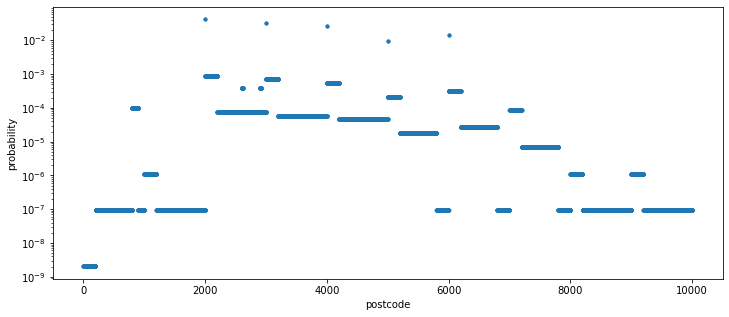

In [45]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.semilogy(samplespace, p3, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

### Conclusion
This prior reflects **precisely** the information we put into the model.

No less:
- all constraints we placed on it are satisfied;

No more:
- no additional information is reflected / assumed which we didn't explicitly add. It is as flat as possible (maximal entropy) subject to our constraints.

In [46]:
np.save('postcode_prior3.npy', p3)

### Aside: Demonstration that we cannot tweak `model` to be equivalent to `model2` by adding one constraint (`in_cbd`) and then minimizing KL divergence from `model1`.

Let's try it ...

In [47]:
model.log_probdist()

array([-22.32221447, -22.32221447, -22.32221447, ..., -15.27472916,
       -15.27472916, -15.27472916])

In [48]:
model.samplespace

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16)

In [49]:
def prior_log_pdf(x):
    return model.log_probdist()[x]

In [50]:
model4 = MinDivergenceModel([in_cbd], samplespace, prior_log_pdf=prior_log_pdf, vectorized=True)

In [51]:
k4 = np.array([0.25], ndmin=2)

In [52]:
model4.fit(k4)

MinDivergenceModel(features=[<function in_cbd at 0x7fe5b4252ee0>],
                   prior_log_pdf=<function prior_log_pdf at 0x7fe5b51bcca0>,
                   samplespace=array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16),
                   vectorized=True)

In [53]:
model4.expectations()

array([0.24999999])

In [54]:
p4 = model4.probdist()

Text(0, 0.5, 'probability')

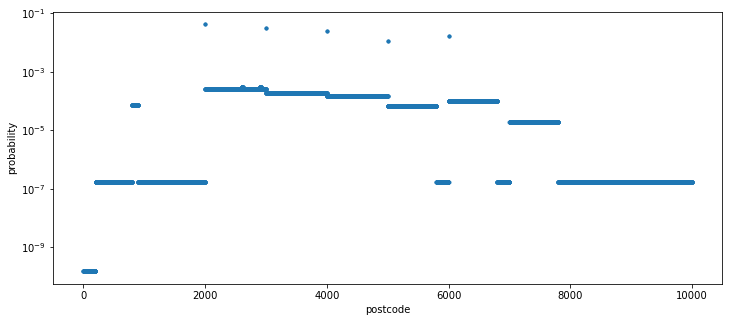

In [55]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.semilogy(samplespace, p4, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

The result is different because the process is different. We are no longer asserting the same constraints as before -- we are only asserting one single constraint. So this will in general have higher entropy (be flatter) than the more constrained model.